In [ ]:
!kaggle datasets download -d shubhamgoel27/dermnet

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1734, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/dermnet.zip &> /dev/null

In [ ]:
import os

def count_images(subfolder_path):
  """Counts the number of images in a folder.

  Args:
      subfolder_path: The path to the subfolder.

  Returns:
      The number of images in the subfolder.
  """
  # Reuse the logic from the previous function to count images in the subfolder
  image_count = sum(1 for f in os.listdir(subfolder_path)
                    if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp")))
  return image_count

folder_path = "/content/drive/MyDrive/new_train"

# Count images in each subfolder
image_counts = {}
for subfolder in os.listdir(folder_path):
  # Check if it's a directory (not a file)
  if os.path.isdir(os.path.join(folder_path, subfolder)):
    subfolder_path = os.path.join(folder_path, subfolder)
    image_counts[subfolder] = count_images(subfolder_path)  # Call the function

# Print image counts for each subfolder
for folder, count in image_counts.items():
  print(f"{folder}, Image Count: {count}")


Lupus and other Connective Tissue diseases, Image Count: 420
Psoriasis pictures Lichen Planus and related diseases, Image Count: 1460
Bullous Disease Photos, Image Count: 458
Eczema Photos, Image Count: 1235
Acne and Rosacea Photos, Image Count: 840


In [ ]:
import os
import numpy as np
import cv2
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50

# Set seeds for reproducibility
np.random.seed(0)
tf.random.set_seed(0)

# Dataset Path
data = '/content'

# Ensure new_train directory exists
if not os.path.exists(os.path.join(data, 'new_train')):
    os.mkdir(os.path.join(data, 'new_train'))

# Copy relevant directories to new_train
!cp -r "/content/drive/MyDrive/new_train/Lupus and other Connective Tissue diseases" /content/new_train
!cp -r "/content/drive/MyDrive/new_train/Psoriasis pictures Lichen Planus and related diseases" /content/new_train
!cp -r "/content/drive/MyDrive/new_train/Eczema Photos" /content/new_train
!cp -r "/content/drive/MyDrive/new_train/Acne and Rosacea Photos" /content/new_train
!cp -r "/content/drive/MyDrive/new_train/Bullous Disease Photos" /content/new_train

# Dataset Path
data_dir = '/content/drive/MyDrive/new_train'

# Function to create a data dictionary
def data_dictionary():
    list_train = [
        'Acne and Rosacea Photos',
        'Lupus and other Connective Tissue diseases',
        'Psoriasis pictures Lichen Planus and related diseases',
        'Eczema Photos',
        'Bullous Disease Photos'
    ]
    train_dictionary = {"image_path": [], "target": []}
    k = 0
    for i in list_train:
        path_disease_train = os.path.join(data_dir, i)
        image_list_train = os.listdir(path_disease_train)
        for j in image_list_train:
            img_path_train = os.path.join(path_disease_train, j)
            train_dictionary["image_path"].append(img_path_train)
            train_dictionary['target'].append(k)
        k += 1
    train_df = pd.DataFrame(train_dictionary)
    return train_df

train = data_dictionary()

# Load images and labels
images = []
labels = []
for img_path in train['image_path']:
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (180, 180))
    images.append(img)
    labels.append(train[train['image_path'] == img_path]['target'].values[0])

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Data shapes
print(images.shape)  # (number_of_images, 180, 180, 3)
print(labels.shape)  # (number_of_images,)

# One-hot encode labels
num_classes = 5
labels = tf.keras.utils.to_categorical(labels, num_classes)

# Load ResNet50 model
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(180, 180, 3))

# Freeze ResNet50 layers
for layer in resnet_model.layers:
    layer.trainable = False

# Flatten the output of ResNet50
x = resnet_model.output
x = tf.keras.layers.Flatten()(x)

# Add fully connected layers
x = Dense(200, activation='relu')(x)
x = Dense(170, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create model
model = Model(inputs=resnet_model.input, outputs=predictions)

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
mcp_save = ModelCheckpoint('model.h5', save_best_only=True, monitor='val_accuracy')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1)

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=0)

# Train model
history = model.fit(x_train, y_train, epochs=3, batch_size=32, validation_split=0.1, callbacks=[mcp_save, reduce_lr])


(4413, 180, 180, 3)
(4413,)
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.3632 - loss: 9.9774

100/100 ━━━━━━━━━━━━━━━━━━━━ 33s 192ms/step - accuracy: 0.3638 - loss: 9.9286 - val_accuracy: 0.5524 - val_loss: 1.5502 - learning_rate: 0.0010
Epoch 2/3
 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7060 - loss: 0.8984

100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.7065 - loss: 0.8962 - val_accuracy: 0.5666 - val_loss: 1.7035 - learning_rate: 0.0010
Epoch 3/3
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.8441 - loss: 0.5149 - val_accuracy: 0.5184 - val_loss: 2.0098 - learning_rate: 0.0010


28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step - accuracy: 0.5562 - loss: 1.8450
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 197ms/step
F1 Score: 0.5458
Accuracy Score: 0.5595
Precision Score: 0.6286
Recall Score: 0.5595


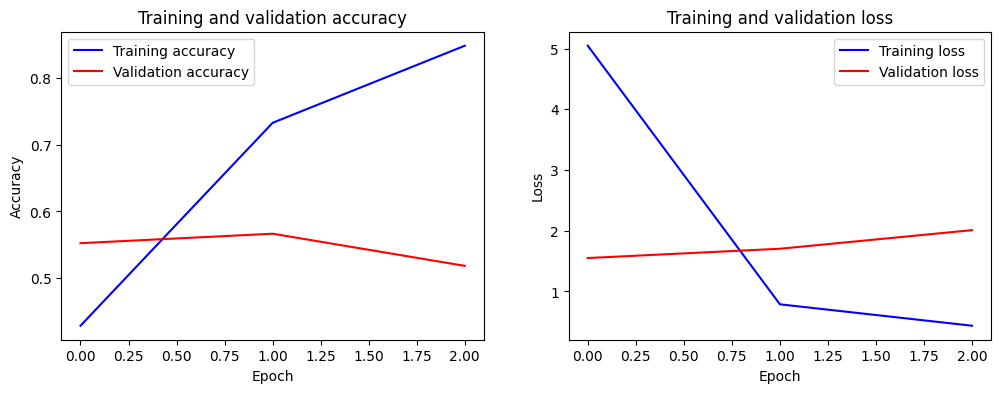

                                                       precision    recall  f1-score   support

                              Acne and Rosacea Photos       0.87      0.40      0.55       168
           Lupus and other Connective Tissue diseases       0.47      0.33      0.39        83
Psoriasis pictures Lichen Planus and related diseases       0.48      0.85      0.61       304
                                        Eczema Photos       0.70      0.47      0.56       241
                               Bullous Disease Photos       0.66      0.31      0.42        87

                                             accuracy                           0.56       883
                                            macro avg       0.63      0.47      0.51       883
                                         weighted avg       0.63      0.56      0.55       883



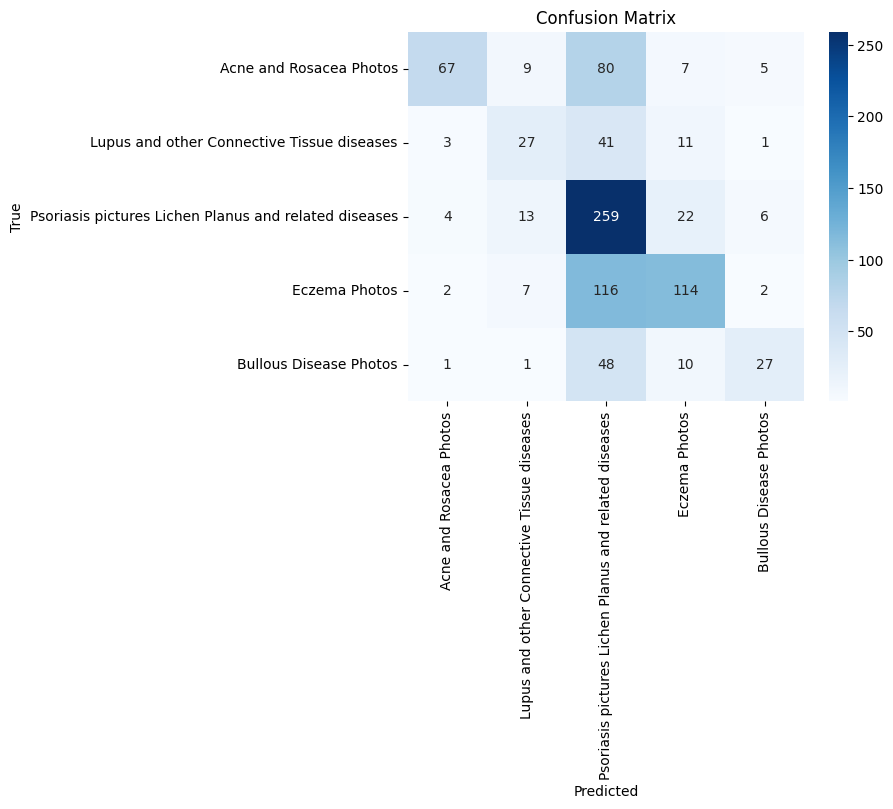

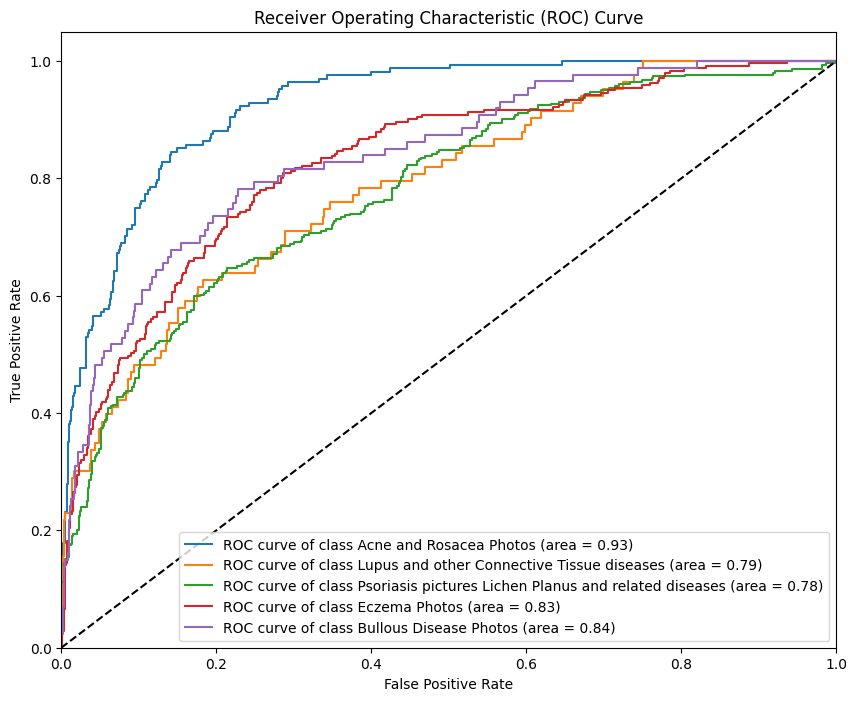

Overall ROC AUC: 0.83


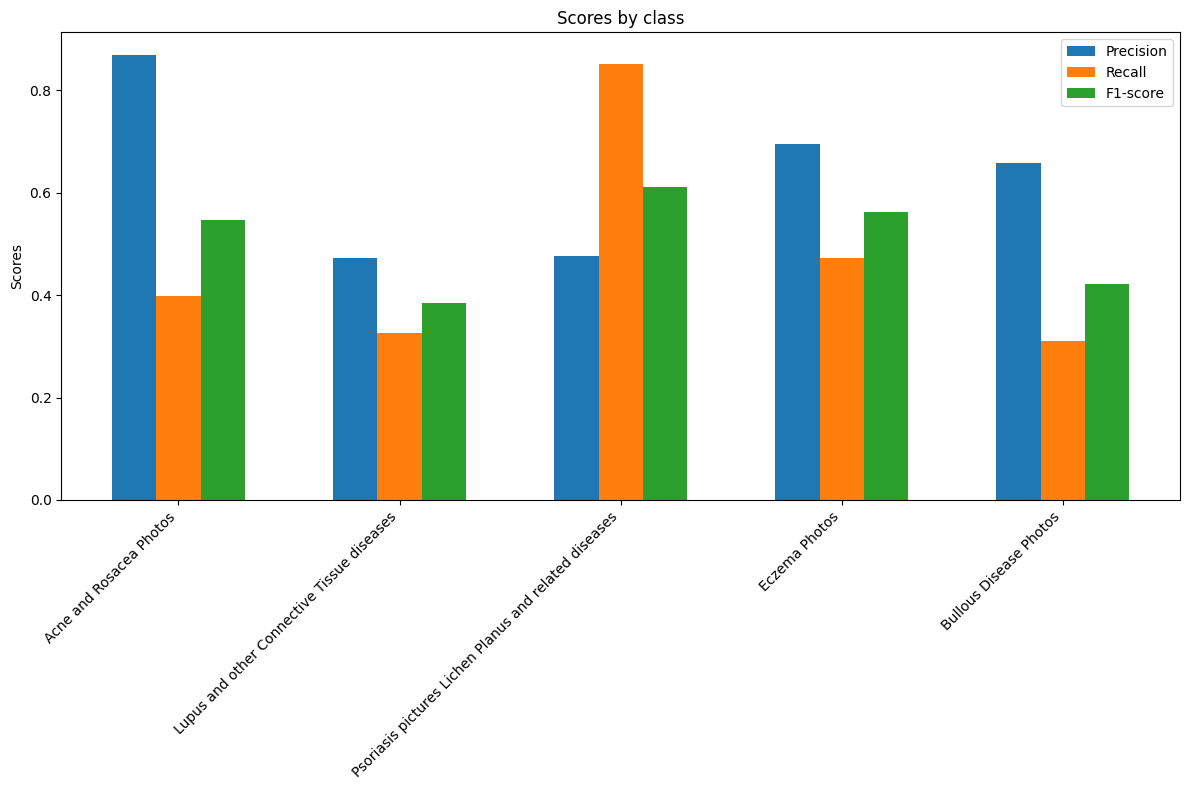

In [ ]:
from sklearn.metrics import (
    confusion_matrix, classification_report, f1_score, accuracy_score,
    precision_score, recall_score, roc_curve, auc, roc_auc_score
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `model` is already trained and `x_test`, `y_test`, and `history` are available

# Evaluate the model
model.evaluate(x_test, y_test)

# Predict and evaluate
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calculate metrics
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')

print(f'F1 Score: {f1:.4f}')
print(f'Accuracy Score: {accuracy:.4f}')
print(f'Precision Score: {precision:.4f}')
print(f'Recall Score: {recall:.4f}')

# Plot accuracy and loss
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(train_accuracy))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Classification report and confusion matrix
class_indices = {
    0: "Acne and Rosacea Photos",
    1: "Lupus and other Connective Tissue diseases",
    2: "Psoriasis pictures Lichen Planus and related diseases",
    3: "Eczema Photos",
    4: "Bullous Disease Photos"
}

print(classification_report(y_true_classes, y_pred_classes, target_names=list(class_indices.values())))

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(class_indices.values()), yticklabels=list(class_indices.values()))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC Curve and AUC
num_classes = len(class_indices)
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {list(class_indices.values())[i]} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Overall ROC AUC
overall_roc_auc = roc_auc_score(y_test, y_pred, average='weighted')
print(f"Overall ROC AUC: {overall_roc_auc:.2f}")

# Plot per-class precision, recall, F1-score
report = classification_report(y_true_classes, y_pred_classes, target_names=list(class_indices.values()), output_dict=True)

labels = list(class_indices.values())
precision = [report[label]['precision'] for label in labels]
recall = [report[label]['recall'] for label in labels]
f1 = [report[label]['f1-score'] for label in labels]

x = np.arange(len(labels))

width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1, width, label='F1-score')

ax.set_ylabel('Scores')
ax.set_title('Scores by class')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend()

fig.tight_layout()

plt.show()


In [ ]:
# Load the saved model
model = tf.keras.models.load_model('model.h5')

# Function to preprocess a single image for prediction
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (180, 180))
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to predict the class of a single image
def predict_image(image_path):
    img = preprocess_image(image_path)
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction, axis=1)
    return predicted_class[0]

# Example usage
test_image_path = '/content/drive/MyDrive/new_train/Acne and Rosacea Photos/07Acne081101.jpg'  # Replace with your test image path
predicted_class = predict_image(test_image_path)
class_labels = [
    'Acne and Rosacea Photos',
    'Lupus and other Connective Tissue diseases',
    'Psoriasis pictures Lichen Planus and related diseases',
    'Eczema Photos',
    'Bullous Disease Photos'
]
print(f"Predicted class: {class_labels[predicted_class]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class: Acne and Rosacea Photos
